## 🌊 Regresión lineal

#### Librerías y ajustes iniciales

In [25]:
import sys

sys.path.append("../../") # go to parent dir

In [26]:
from sklearn.linear_model import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from modelos import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [27]:
pd.options.display.max_columns = 50 # para mostrar todas las columnas

### 🔨 Construcción de modelos

#### Separación en train y test

In [28]:
# Para el modelo con todas las variables
X_train, X_test, y_train, y_test = sep_train_test()
# Eliminamos las columnas repetidas y las columnas temporales (visto en el notebook del analisis)
X_train = X_train.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])
X_test = X_test.drop(columns=["Temperatura", 'wspd', 'anio', 'mes', 'dia', 'hora'])

#### Distribuciones de a variable respuesta en train y test

Text(0.5, 0, 'metros')

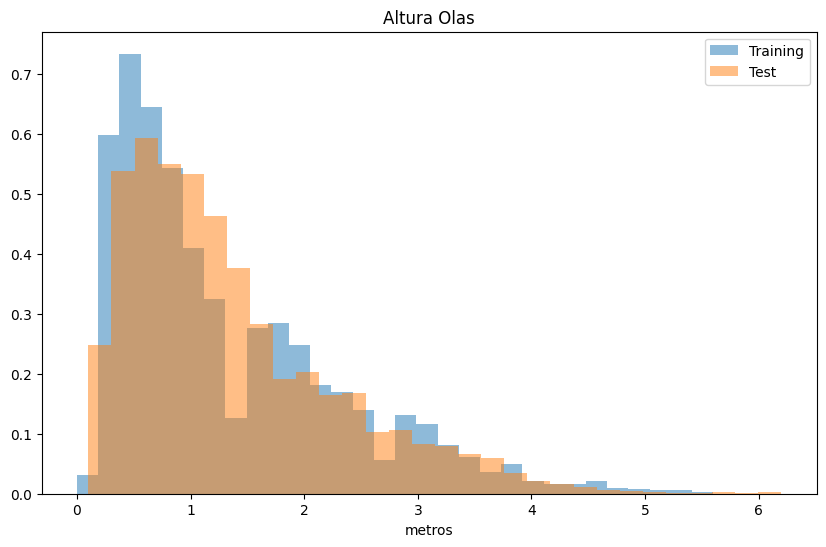

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(y_train, bins=30, alpha=0.5, label='Training', density=True)
ax.hist(y_test, bins=30, alpha=0.5, label='Test', density=True)
plt.legend()
plt.title("Altura Olas")
plt.xlabel("metros")

Analizando las funciones de densidad de los dos conjuntos vemos que se parecen bastante, a excepción de las olas de altura alrededor de 0.5 metros, las cuáles parecen estar en mayor proporción en training que en el conjunto test.

#### Definimos funciones auxiliares para evitar repetir mucho codigo

In [30]:
def lineal_sin_reg(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo regresión lineal multivariable sin regularizar"):
    flo = MLFlow("lineal_sin_reg")
    lr = LinearRegression()
    cv_metrics = cross_validate(lr, x_tr, y_tr, cv=cv_folds(), scoring="neg_root_mean_squared_error", return_train_score=True)
    lr.fit(x_tr, y_tr)
    
    # metricas TEST
    metricas = calcular_metricas(y_te, lr.predict(x_te))
    # metricas CV
    metricas["CV_TEST_RMSE"] = -1 * cv_metrics['test_score'].mean()
    metricas["CV_TRAIN_RMSE"] = -1 * cv_metrics['train_score'].mean()
    print("LINEAR")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, lr, {"random_state": RANDOM_SEED}, metricas, run_name, exp_info)

In [31]:
def ridge(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo ridge"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "solver": ['svd', 'cholesky', 'lsqr'],
        "max_iter": [None, 100, 500, 1000],
    }
    flo = MLFlow("ridge")

    rdgSearch = GridSearchCV(Ridge(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rdgSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(rdgSearch, x_te, y_te)
    print("RIDGE GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, rdgSearch.best_estimator_, rdgSearch.best_params_, metricas, run_name, exp_info)

    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 1)],
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        "max_iter": [None, 100, 500, 1000],
    }
    
    rdgRanSearch = RandomizedSearchCV(Ridge(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    rdgRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(rdgRanSearch, x_te, y_te)
    print("RIDGE RANDOMSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, rdgRanSearch.best_estimator_, rdgRanSearch.best_params_, metricas, run_name, exp_info)

    

In [32]:
def lasso(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo lasso"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "selection": ['cyclic', 'random'],
        "max_iter": [None, 100, 500, 1000, 2000],
    }
    flo = MLFlow("lasso")

    lasSearch = GridSearchCV(Lasso(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    lasSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(lasSearch, x_te, y_te)
    print("LASSO GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, lasSearch.best_estimator_, lasSearch.best_params_, metricas, run_name, exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 1)],
        "selection": ['cyclic', 'random'],
        "max_iter": [None, 100, 500, 1000, 2000],
    }
    
    lasRanSearch = RandomizedSearchCV(Lasso(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    lasRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(lasRanSearch, x_te, y_te)
    print("LASSO RANDOMSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, lasRanSearch.best_estimator_, lasRanSearch.best_params_, metricas, run_name, exp_info)


In [33]:
def elastic(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo elastic net"):
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 10)],
        "l1_ratio": [i/100 for i in range(0, 101, 10)],
        "max_iter": [None, 500],
    }
    flo = MLFlow("elastic")

    elSearch = GridSearchCV(ElasticNet(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    elSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(elSearch, x_te, y_te)
    print("ELASTIC GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, elSearch.best_estimator_, elSearch.best_params_, metricas, run_name, exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "alpha": [i/100 for i in range(1, 101, 5)],
        "l1_ratio": [i/100 for i in range(0, 101, 5)],
        "max_iter": [None, 100, 500, 1000],
    }
    
    elRanSearch = RandomizedSearchCV(ElasticNet(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    elRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(elRanSearch, x_te, y_te)
    print("ELASTIC RANDOMSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, elRanSearch.best_estimator_, elRanSearch.best_params_, metricas, run_name, exp_info)

In [34]:
def SVM(x_tr, x_te, y_tr, y_te, run_name, exp_info="Modelo SVM con kernel lineal"):
    params = {
        "random_state": [RANDOM_SEED],
        "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        "C": np.logspace(-3, 3, 25),
        "max_iter": [100, 250, 500],
    }
    flo = MLFlow("svm")

    svmSearch = GridSearchCV(LinearSVR(), params, cv=cv_folds(), return_train_score=True, scoring="neg_root_mean_squared_error", n_jobs=-1)
    svmSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(svmSearch, x_te, y_te)
    print("SVM GRIDSEARCH")
    print(metricas)
    flo.persist_model_to_mlflow(x_tr, svmSearch.best_estimator_, svmSearch.best_params_, metricas, run_name, exp_info)
    
    # Random para probar más parametros
    params = {
        "random_state": [RANDOM_SEED],
        "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        "C": np.logspace(-3, 3, 100),
        "max_iter": [100, 250, 500, 750, 1000],
    }
    
    svmRanSearch = RandomizedSearchCV(LinearSVR(), params, cv=cv_folds(), n_iter=200, return_train_score=True, random_state=RANDOM_SEED, scoring="neg_root_mean_squared_error", n_jobs=-1)
    svmRanSearch.fit(x_tr, y_tr)
    metricas = calcular_metricas_search(svmRanSearch, x_te, y_te)
    print("SVM RANDOMSEARCH")
    print(metricas)
    
    flo.persist_model_to_mlflow(x_tr, svmRanSearch.best_estimator_, svmRanSearch.best_params_, metricas, run_name, exp_info)

### Modelos usando el conjunto de datos completo

In [35]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'dewPt', 'heat_index',
                                  'rh', 'pressure', 'vis', 'wc', 'feels_like',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

#### Modelo lineal sin regularización

In [36]:
lineal_sin_reg(X_train, X_test, y_train, y_test, "lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.3924967961023205, 'TEST_ROOT_MEAN_SQ_ERROR': 0.49278774590513297, 'TEST_MEDIAN_ABS_ERROR': 0.31135520503023806, 'TEST_MEAN_ABS_ERROR': 0.3820656755906809, 'CV_TEST_RMSE': 0.4672807059072115, 'CV_TRAIN_RMSE': 0.4641326077038605}


Registered model 'lineal-sin-regularizar' already exists. Creating a new version of this model...
2024/04/16 20:12:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lineal-sin-regularizar, version 3
Created version '3' of model 'lineal-sin-regularizar'.


In [37]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.3546404974243327, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569855088064947, 'TEST_MEDIAN_ABS_ERROR': 0.27932137147789604, 'TEST_MEAN_ABS_ERROR': 0.35133992706891015, 'CV_TEST_RMSE': 0.46729693184611987, 'CV_TRAIN_RMSE': 0.4641378143807886}


Registered model 'esc-lineal-sin-regularizar' already exists. Creating a new version of this model...
2024/04/16 20:12:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-lineal-sin-regularizar, version 3
Created version '3' of model 'esc-lineal-sin-regularizar'.


Vemos que al escalar aparece una mejora en todas las métricas en el conjunto test, aunque el caso de train las métricas empeoran muy poco.

#### Modelo RIDGE

In [38]:
ridge(X_train, X_test, y_train, y_test, "ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.3602796242149005, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4571852402224735, 'TEST_MEDIAN_ABS_ERROR': 0.2807678714799405, 'TEST_MEAN_ABS_ERROR': 0.3515511661585721, 'CV_TEST_RMSE': 0.4672549958034491, 'CV_TRAIN_RMSE': 0.4642071973669184}


Registered model 'ridge' already exists. Creating a new version of this model...
2024/04/16 20:12:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge, version 5
Created version '5' of model 'ridge'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: Conv

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3531787208611483, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4563938594375065, 'TEST_MEDIAN_ABS_ERROR': 0.27957397667003825, 'TEST_MEAN_ABS_ERROR': 0.3508746796097043, 'CV_TEST_RMSE': 0.46719788670283807, 'CV_TRAIN_RMSE': 0.4641718321753362}


Registered model 'ridge' already exists. Creating a new version of this model...
2024/04/16 20:12:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge, version 6
Created version '6' of model 'ridge'.


In [39]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.355928065202297, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45693540222874396, 'TEST_MEDIAN_ABS_ERROR': 0.2799912960898051, 'TEST_MEAN_ABS_ERROR': 0.35131689877017214, 'CV_TEST_RMSE': 0.4672402071370792, 'CV_TRAIN_RMSE': 0.4641458551070413}


Registered model 'esc-ridge' already exists. Creating a new version of this model...
2024/04/16 20:13:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-ridge, version 4
Created version '4' of model 'esc-ridge'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3559353001746732, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569347464287433, 'TEST_MEDIAN_ABS_ERROR': 0.2799880998267854, 'TEST_MEAN_ABS_ERROR': 0.35131630875357645, 'CV_TEST_RMSE': 0.46724010842665314, 'CV_TRAIN_RMSE': 0.4641458646153998}


Registered model 'esc-ridge' already exists. Creating a new version of this model...
2024/04/16 20:13:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-ridge, version 5
Created version '5' of model 'esc-ridge'.


Vemos que al escalar aparece una mejora en todas las métricas en el conjunto test. Además, son mejores que en el anterior modelo. Mencionar que el random search encuentra una mejor combinación de parámteros

#### Modelo LASSO

In [40]:
lasso(X_train, X_test, y_train, y_test, "lasso")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.709e+01, tolerance: 3.761e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.779e+01, tolerance: 3.740e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.3853832257290435, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4549195856756683, 'TEST_MEDIAN_ABS_ERROR': 0.2816930125817354, 'TEST_MEAN_ABS_ERROR': 0.3509525324191503, 'CV_TEST_RMSE': 0.47542496241325016, 'CV_TRAIN_RMSE': 0.4740070044043908}


Registered model 'lasso' already exists. Creating a new version of this model...
2024/04/16 20:13:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lasso, version 3
Created version '3' of model 'lasso'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.914e+00, tolerance: 3.761e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e+00, tolerance: 3.791e-01
  mode

LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3854133118335348, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45491700469692087, 'TEST_MEDIAN_ABS_ERROR': 0.2817499787362401, 'TEST_MEAN_ABS_ERROR': 0.35095124855575865, 'CV_TEST_RMSE': 0.47542573340911565, 'CV_TRAIN_RMSE': 0.4740061388373914}


Registered model 'lasso' already exists. Creating a new version of this model...
2024/04/16 20:13:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lasso, version 4
Created version '4' of model 'lasso'.


In [41]:
lasso(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-lasso")

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.4498606560859106, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570765064478258, 'TEST_MEDIAN_ABS_ERROR': 0.2842102401459931, 'TEST_MEAN_ABS_ERROR': 0.35135992046605474, 'CV_TEST_RMSE': 0.47652691416331133, 'CV_TRAIN_RMSE': 0.475195882350794}


Registered model 'esc-lasso' already exists. Creating a new version of this model...
2024/04/16 20:13:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-lasso, version 3
Created version '3' of model 'esc-lasso'.


LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4498606560859106, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570765064478258, 'TEST_MEDIAN_ABS_ERROR': 0.2842102401459931, 'TEST_MEAN_ABS_ERROR': 0.35135992046605474, 'CV_TEST_RMSE': 0.47652691416331133, 'CV_TRAIN_RMSE': 0.475195882350794}


Registered model 'esc-lasso' already exists. Creating a new version of this model...
2024/04/16 20:13:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-lasso, version 4
Created version '4' of model 'esc-lasso'.


Sorprendentemente, Lasso predice peor si escalamos los datos. Además, este modelo predice peor que los modelos escalados de ridge y linear regression

#### Modelo ELASTIC NET

In [42]:
elastic(X_train, X_test, y_train, y_test, "elastic")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.214e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.198e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.34547582441855, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45362121485907814, 'TEST_MEDIAN_ABS_ERROR': 0.2785247075974797, 'TEST_MEAN_ABS_ERROR': 0.3484665785286415, 'CV_TEST_RMSE': 0.4680809696669477, 'CV_TRAIN_RMSE': 0.4652965889129111}


Registered model 'elastic' already exists. Creating a new version of this model...
2024/04/16 20:13:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: elastic, version 3
Created version '3' of model 'elastic'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.290e+01, tolerance: 3.834e-01
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.755e+02, tolerance: 3.791e-01 

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3506075129027693, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4530781518435188, 'TEST_MEDIAN_ABS_ERROR': 0.2794537684444716, 'TEST_MEAN_ABS_ERROR': 0.34828107949039866, 'CV_TEST_RMSE': 0.46865042113198474, 'CV_TRAIN_RMSE': 0.466200618364138}


Registered model 'elastic' already exists. Creating a new version of this model...
2024/04/16 20:13:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: elastic, version 4
Created version '4' of model 'elastic'.


In [ ]:
elastic(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-elastic")

En este caso igual que Lasso, predice peor al escalar los datos. Si no escalamos los datos parecer ser que es el mejor modelo hasta ahora.

#### Modelo SVM

In [44]:
SVM(X_train, X_test, y_train, y_test, "svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tyomikjan/UN

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.379724330205505, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4961527849411968, 'TEST_MEDIAN_ABS_ERROR': 0.30492756381164865, 'TEST_MEAN_ABS_ERROR': 0.3805764169398917, 'CV_TEST_RMSE': 0.5149813737717907, 'CV_TRAIN_RMSE': 0.5124349283191163}


Registered model 'svm' already exists. Creating a new version of this model...
2024/04/16 20:14:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: svm, version 3
Created version '3' of model 'svm'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `d

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.400264826222257, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4944087556328888, 'TEST_MEDIAN_ABS_ERROR': 0.30213068008201094, 'TEST_MEAN_ABS_ERROR': 0.3782386655702108, 'CV_TEST_RMSE': 0.5130689334300995, 'CV_TRAIN_RMSE': 0.5102391802762924}


Registered model 'svm' already exists. Creating a new version of this model...
2024/04/16 20:15:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: svm, version 4
Created version '4' of model 'svm'.


In [45]:
SVM(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.35928970117286, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45724447144150193, 'TEST_MEDIAN_ABS_ERROR': 0.2807299841198926, 'TEST_MEAN_ABS_ERROR': 0.35150102827358043, 'CV_TEST_RMSE': 0.46720562731692716, 'CV_TRAIN_RMSE': 0.4641700594671675}


Registered model 'esc-svm' already exists. Creating a new version of this model...
2024/04/16 20:15:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-svm, version 3
Created version '3' of model 'esc-svm'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3590447413982703, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4573482451823263, 'TEST_MEDIAN_ABS_ERROR': 0.280692640543055, 'TEST_MEAN_ABS_ERROR': 0.3515733064372614, 'CV_TEST_RMSE': 0.4672063349831044, 'CV_TRAIN_RMSE': 0.4641727820304178}


Registered model 'esc-svm' already exists. Creating a new version of this model...
2024/04/16 20:15:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-svm, version 4
Created version '4' of model 'esc-svm'.


El que más tiempo ha tardado en ejecutar. En este caso el escalado ayuda, pero no consigue mejorar el resultado de ElasticNet

### Modelo usando selección de variables MANUAL

#### Seleccion de variables

In [46]:
cols = ['moonphase', 'temp', 'rh', 'pressure',
       'vis', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N',
       'wdir_NE', 'wdir_NNE', 'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE',
       'wdir_SSE', 'wdir_SSW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW',
       'wdir_WSW', 'Vviento', 'PeriodoOlas', 'Lluvia', 'Nubosidad']
# guardamos para poder usar despues en el ajuste automatico
X_train_full = X_train.copy()
X_test_full = X_test.copy()

X_train = X_train[cols]
X_test = X_test[cols]

In [47]:
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['moonphase', 'temp', 'rh', 'pressure', 'vis',
                                  'uv_index', 'Vviento', 'PeriodoOlas',
                                  'Lluvia', 'Nubosidad'])])

#### Modelo lineal sin regularización

In [48]:
lineal_sin_reg(X_train, X_test, y_train, y_test, "sel-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.3925406083885363, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45700269100202406, 'TEST_MEDIAN_ABS_ERROR': 0.28138712684071376, 'TEST_MEAN_ABS_ERROR': 0.35054774227298535, 'CV_TEST_RMSE': 0.46959551051187826, 'CV_TRAIN_RMSE': 0.4665570508791218}


Registered model 'sel-lineal-sin-regularizar' already exists. Creating a new version of this model...
2024/04/16 20:15:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-lineal-sin-regularizar, version 2
Created version '2' of model 'sel-lineal-sin-regularizar'.


In [49]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 2.392540608388522, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45700269100202534, 'TEST_MEDIAN_ABS_ERROR': 0.2813871268407142, 'TEST_MEAN_ABS_ERROR': 0.35054774227298624, 'CV_TEST_RMSE': 0.4695955105118784, 'CV_TRAIN_RMSE': 0.4665570508791218}


Registered model 'esc-sel-lineal-sin-regularizar' already exists. Creating a new version of this model...
2024/04/16 20:15:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-lineal-sin-regularizar, version 2
Created version '2' of model 'esc-sel-lineal-sin-regularizar'.


#### Modelo RIDGE

In [50]:
ridge(X_train, X_test, y_train, y_test, "sel-ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.3990459841151157, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45681929545031036, 'TEST_MEDIAN_ABS_ERROR': 0.2823021900635275, 'TEST_MEAN_ABS_ERROR': 0.3505093894592272, 'CV_TEST_RMSE': 0.46951218743240786, 'CV_TRAIN_RMSE': 0.46659857617126577}


Registered model 'sel-ridge' already exists. Creating a new version of this model...
2024/04/16 20:15:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-ridge, version 3
Created version '3' of model 'sel-ridge'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.

RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.399042525045367, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45681808388169953, 'TEST_MEDIAN_ABS_ERROR': 0.2822958645238195, 'TEST_MEAN_ABS_ERROR': 0.35050827646270294, 'CV_TEST_RMSE': 0.4695121063442468, 'CV_TRAIN_RMSE': 0.46659859120194136}


Registered model 'sel-ridge' already exists. Creating a new version of this model...
2024/04/16 20:16:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-ridge, version 4
Created version '4' of model 'sel-ridge'.


In [51]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 2.3928110734348498, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569652866621609, 'TEST_MEDIAN_ABS_ERROR': 0.28153880600745995, 'TEST_MEAN_ABS_ERROR': 0.35051929639965707, 'CV_TEST_RMSE': 0.4695795883667847, 'CV_TRAIN_RMSE': 0.466557585782191}


Registered model 'esc-sel-ridge' already exists. Creating a new version of this model...
2024/04/16 20:16:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-ridge, version 3
Created version '3' of model 'esc-sel-ridge'.


RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3929768433198553, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4569492534339473, 'TEST_MEDIAN_ABS_ERROR': 0.2815494287147423, 'TEST_MEAN_ABS_ERROR': 0.3505091970393953, 'CV_TEST_RMSE': 0.46957076287179345, 'CV_TRAIN_RMSE': 0.46655755956366696}


Registered model 'esc-sel-ridge' already exists. Creating a new version of this model...
2024/04/16 20:16:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-ridge, version 4
Created version '4' of model 'esc-sel-ridge'.


#### Modelo LASSO (no cambia apenas el resultado, pues el algoritmo ya se encarga de quitar variables por su cuenta)

In [52]:
lasso(X_train, X_test, y_train, y_test, "sel-lasso")

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.417516751239333, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4554368874019835, 'TEST_MEDIAN_ABS_ERROR': 0.28056516246359636, 'TEST_MEAN_ABS_ERROR': 0.35045989391095855, 'CV_TEST_RMSE': 0.4775145318250624, 'CV_TRAIN_RMSE': 0.4762049187592563}


Registered model 'sel-lasso' already exists. Creating a new version of this model...
2024/04/16 20:16:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-lasso, version 3
Created version '3' of model 'sel-lasso'.


LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.417516751239333, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4554368874019835, 'TEST_MEDIAN_ABS_ERROR': 0.28056516246359636, 'TEST_MEAN_ABS_ERROR': 0.35045989391095855, 'CV_TEST_RMSE': 0.4775145318250624, 'CV_TRAIN_RMSE': 0.4762049187592563}


Registered model 'sel-lasso' already exists. Creating a new version of this model...
2024/04/16 20:16:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-lasso, version 4
Created version '4' of model 'sel-lasso'.


In [53]:
lasso(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-lasso")

LASSO GRIDSEARCH
{'TEST_MAX_ERROR': 2.4498019293106763, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570786476870413, 'TEST_MEDIAN_ABS_ERROR': 0.2842329327858378, 'TEST_MEAN_ABS_ERROR': 0.35136276157172674, 'CV_TEST_RMSE': 0.4765272916725132, 'CV_TRAIN_RMSE': 0.47519595842307594}


Registered model 'esc-sel-lasso' already exists. Creating a new version of this model...
2024/04/16 20:16:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-lasso, version 3
Created version '3' of model 'esc-sel-lasso'.


LASSO RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4498019293106763, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4570786476870413, 'TEST_MEDIAN_ABS_ERROR': 0.2842329327858378, 'TEST_MEAN_ABS_ERROR': 0.35136276157172674, 'CV_TEST_RMSE': 0.4765272916725132, 'CV_TRAIN_RMSE': 0.47519595842307594}


Registered model 'esc-sel-lasso' already exists. Creating a new version of this model...
2024/04/16 20:16:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-lasso, version 4
Created version '4' of model 'esc-sel-lasso'.


#### Modelo ELASTIC NET

In [54]:
elastic(X_train, X_test, y_train, y_test, "sel-elastic")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.232e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.261e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.3829917588509737, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45366150866373955, 'TEST_MEDIAN_ABS_ERROR': 0.2767432216097617, 'TEST_MEAN_ABS_ERROR': 0.3477178870129286, 'CV_TEST_RMSE': 0.47036768813569463, 'CV_TRAIN_RMSE': 0.4677005978451511}


Registered model 'sel-elastic' already exists. Creating a new version of this model...
2024/04/16 20:16:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-elastic, version 3
Created version '3' of model 'sel-elastic'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.777e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: 

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.3913224529925046, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45301151887989294, 'TEST_MEDIAN_ABS_ERROR': 0.27530091976344623, 'TEST_MEAN_ABS_ERROR': 0.34745668759912285, 'CV_TEST_RMSE': 0.47089499892908754, 'CV_TRAIN_RMSE': 0.4685658025638534}


Registered model 'sel-elastic' already exists. Creating a new version of this model...
2024/04/16 20:16:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-elastic, version 4
Created version '4' of model 'sel-elastic'.


In [55]:
elastic(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-elastic")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.203e+02, tolerance: 3.761e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.180e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

ELASTIC GRIDSEARCH
{'TEST_MAX_ERROR': 2.4121208025359966, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4554009508008006, 'TEST_MEDIAN_ABS_ERROR': 0.28074490176573413, 'TEST_MEAN_ABS_ERROR': 0.34946875947503175, 'CV_TEST_RMSE': 0.46952610525172583, 'CV_TRAIN_RMSE': 0.4668069814052659}


Registered model 'esc-sel-elastic' already exists. Creating a new version of this model...
2024/04/16 20:16:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-elastic, version 3
Created version '3' of model 'esc-sel-elastic'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.445e+02, tolerance: 3.791e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: Converge

ELASTIC RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4192594010834987, 'TEST_ROOT_MEAN_SQ_ERROR': 0.45474909751054043, 'TEST_MEDIAN_ABS_ERROR': 0.28087049735482206, 'TEST_MEAN_ABS_ERROR': 0.34907645533434106, 'CV_TEST_RMSE': 0.47007209257000593, 'CV_TRAIN_RMSE': 0.4676263884721192}


Registered model 'esc-sel-elastic' already exists. Creating a new version of this model...
2024/04/16 20:16:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-elastic, version 4
Created version '4' of model 'esc-sel-elastic'.


#### Modelo SVM

In [56]:
SVM(X_train, X_test, y_train, y_test, "sel-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.550702982860348, 'TEST_ROOT_MEAN_SQ_ERROR': 0.5168654530940198, 'TEST_MEDIAN_ABS_ERROR': 0.31562627476533456, 'TEST_MEAN_ABS_ERROR': 0.3952089192893805, 'CV_TEST_RMSE': 0.5273318970429398, 'CV_TRAIN_RMSE': 0.5252422549712525}


Registered model 'sel-svm' already exists. Creating a new version of this model...
2024/04/16 20:17:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-svm, version 3
Created version '3' of model 'sel-svm'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.523719418856463, 'TEST_ROOT_MEAN_SQ_ERROR': 0.5160684932182225, 'TEST_MEDIAN_ABS_ERROR': 0.3187196020488016, 'TEST_MEAN_ABS_ERROR': 0.3961860678554849, 'CV_TEST_RMSE': 0.5265749775240571, 'CV_TRAIN_RMSE': 0.5243033429262859}


Registered model 'sel-svm' already exists. Creating a new version of this model...
2024/04/16 20:17:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: sel-svm, version 4
Created version '4' of model 'sel-svm'.


In [57]:
SVM(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-sel-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 2.4021080595846795, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4612150587826764, 'TEST_MEDIAN_ABS_ERROR': 0.2821305510477732, 'TEST_MEAN_ABS_ERROR': 0.35286950438711273, 'CV_TEST_RMSE': 0.46951607934211187, 'CV_TRAIN_RMSE': 0.4669380568427912}


Registered model 'esc-sel-svm' already exists. Creating a new version of this model...
2024/04/16 20:18:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-svm, version 3
Created version '3' of model 'esc-sel-svm'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 2.4022829637578518, 'TEST_ROOT_MEAN_SQ_ERROR': 0.4613265856295621, 'TEST_MEDIAN_ABS_ERROR': 0.28200606100201864, 'TEST_MEAN_ABS_ERROR': 0.352932566089318, 'CV_TEST_RMSE': 0.46951391578763896, 'CV_TRAIN_RMSE': 0.4669565343952198}


Registered model 'esc-sel-svm' already exists. Creating a new version of this model...
2024/04/16 20:18:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-sel-svm, version 4
Created version '4' of model 'esc-sel-svm'.


En general, podemos decir que la selección de variables manual ha empeorado los resultados, sobre todo reflejandose en el TEST_MAX_ERROR. Excepto para Elastic Net, en el cual ha conseguido la menor raiz de MCE

### Modelo usando selección de variables AUTOMATICA
(solo modelos Ridge, LinearRegression y SVM, sobre datos ESCALADOS porque se han tenido en cuenta las variables escaladas en la selección)

#### Modelo lineal sin regularización

In [58]:
cols = ['dewPt', 'rh', 'pressure', 'wc', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR', 'PeriodoOlas', 'Nubosidad']

X_train = X_train_full[cols]
X_test = X_test_full[cols]
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['dewPt', 'rh', 'pressure', 'wc', 'uv_index',
                                  'PeriodoOlas', 'Nubosidad'])])

In [59]:
lineal_sin_reg(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-selauto-lineal-sin-regularizar")

LINEAR
{'TEST_MAX_ERROR': 3.5343248135498246, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6717436563340571, 'TEST_MEDIAN_ABS_ERROR': 0.43987798686646384, 'TEST_MEAN_ABS_ERROR': 0.5280188527538002, 'CV_TEST_RMSE': 0.6706479034916522, 'CV_TRAIN_RMSE': 0.669061567904042}


Registered model 'esc-selauto-lineal-sin-regularizar' already exists. Creating a new version of this model...
2024/04/16 20:18:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-selauto-lineal-sin-regularizar, version 2
Created version '2' of model 'esc-selauto-lineal-sin-regularizar'.


#### Modelo RIDGE

In [60]:
cols = ['dewPt', 'rh', 'pressure', 'wc', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR', 'PeriodoOlas', 'Nubosidad']

X_train = X_train_full[cols]
X_test = X_test_full[cols]
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['dewPt', 'rh', 'pressure', 'wc', 'uv_index',
                                  'PeriodoOlas', 'Nubosidad'])])

In [61]:
ridge(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-selauto-ridge")

RIDGE GRIDSEARCH
{'TEST_MAX_ERROR': 3.534871336284998, 'TEST_ROOT_MEAN_SQ_ERROR': 0.671734735819351, 'TEST_MEDIAN_ABS_ERROR': 0.43982596578096533, 'TEST_MEAN_ABS_ERROR': 0.5280090870575266, 'CV_TEST_RMSE': 0.6706424917613472, 'CV_TRAIN_RMSE': 0.6690626975538295}


Registered model 'esc-selauto-ridge' already exists. Creating a new version of this model...
2024/04/16 20:18:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-selauto-ridge, version 3
Created version '3' of model 'esc-selauto-ridge'.


RIDGE RANDOMSEARCH
{'TEST_MAX_ERROR': 3.5348768249045968, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6717346228072355, 'TEST_MEDIAN_ABS_ERROR': 0.4398172597746784, 'TEST_MEAN_ABS_ERROR': 0.5280089769637228, 'CV_TEST_RMSE': 0.6706424535229667, 'CV_TRAIN_RMSE': 0.6690627204586874}


Registered model 'esc-selauto-ridge' already exists. Creating a new version of this model...
2024/04/16 20:18:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-selauto-ridge, version 4
Created version '4' of model 'esc-selauto-ridge'.


#### Modelo SVM

In [62]:
cols = ['temp', 'dewPt', 'rh', 'pressure', 'wc', 'feels_like', 'uv_index', 'wdir_E', 'wdir_ENE', 'wdir_NE', 'wdir_NW', 'wdir_SW', 'wdir_VAR', 'wdir_W', 'Nubosidad']

X_train = X_train_full[cols]
X_test = X_test_full[cols]
# Para probar con datos escalados
scaler = ColumnTransformer(
    transformers=[
        # no escalonamos las dummy de dirección de viento
        ("num", StandardScaler(), [c for c in X_train.columns if not c.startswith('wdir_')]),
    ],
    remainder='passthrough'
)
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['temp', 'dewPt', 'rh', 'pressure', 'wc',
                                  'feels_like', 'uv_index', 'Nubosidad'])])

In [63]:
SVM(scaler.transform(X_train), scaler.transform(X_test), y_train, y_test, "esc-selauto-svm")

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitl

SVM GRIDSEARCH
{'TEST_MAX_ERROR': 3.5984539922664, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6899742671594232, 'TEST_MEDIAN_ABS_ERROR': 0.44368347717436013, 'TEST_MEAN_ABS_ERROR': 0.5421519774154823, 'CV_TEST_RMSE': 0.6900851809667083, 'CV_TRAIN_RMSE': 0.6886484366635813}


Registered model 'esc-selauto-svm' already exists. Creating a new version of this model...
2024/04/16 20:19:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-selauto-svm, version 3
Created version '3' of model 'esc-selauto-svm'.
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to 

SVM RANDOMSEARCH
{'TEST_MAX_ERROR': 3.5979710894439982, 'TEST_ROOT_MEAN_SQ_ERROR': 0.6899859663743758, 'TEST_MEDIAN_ABS_ERROR': 0.44314069934112915, 'TEST_MEAN_ABS_ERROR': 0.5421728339789633, 'CV_TEST_RMSE': 0.6900865003319284, 'CV_TRAIN_RMSE': 0.6886639654017189}


Registered model 'esc-selauto-svm' already exists. Creating a new version of this model...
2024/04/16 20:19:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: esc-selauto-svm, version 4
Created version '4' of model 'esc-selauto-svm'.


El ajuste automático de columnas no ha funcionado como queríamos, pues ha empeorado sustancialmente casi todas las métricas de los modelos. Esto se debe a que estabamos seleccionando las columnas en función de los hiperparámetros por defecto en vez de hacerlo en cada iteración lo cuál podría verse limitado por la capacidad de cómputo de nuestros ordenadores.

### Conclusión

En este caso hemos visto que:
1. Al escalar los modelos hay modelos que mejoran en las métricas fijadas(Linear, Ridge, SVM) y otros que empeoran (Lasso, Elastic)
2. El modelo de Elastic Net en sus versiones de cada conjunto de columnas suele ser el mejor en cuanto a las métricas
3. El escalado mejora mucho el rendimiento y acelera el entrenamiento del modelo
4. El modelo de SVM no es el mejor para esta tarea